### Notebook zawiera kolejne kroki jakie doprowadziły mnie do ostatecznej wersji rozwiązania. 

### Podstawowe założenie: predykcja nie może być oparta o dane z przyszłości.

### basic analysis
Wykorzystywałem niektóre notebooki udostępnione przez grupę warszawską.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab 
import scipy.stats as stats
from tqdm import tqdm_notebook as tqdm
from math import sqrt

np.random.seed(0)

from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

from sklearn.model_selection import KFold, TimeSeriesSplit, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer, accuracy_score
from ml_metrics import rmse

from scikitplot.estimators import plot_learning_curve

from sklearn.dummy import DummyRegressor
import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# stworzenie nowego indeksu z zachowaniem pierwotnego w polu 'id'
# pole daty nie zostało wykorzystane jako indeks
train = pd.read_hdf('train_warsaw.h5')
train = train.rename(columns={'timestamp': 'date'}).reset_index()
train.drop( columns=['timestamp'], inplace = True)
test = pd.read_hdf('test_warsaw.h5')
test = test.rename(columns={'timestamp': 'date'}).reset_index()
test.drop( columns=['timestamp'], inplace = True)

In [3]:
train.shape, test.shape

((38952, 22), (1200, 3))

### ocena wartości brakujących
W dalszej analizie dane brakujące nie były wycinane ani konwertowane
Można zweryfikować hipotezę ze Slacka, że wycięcie tych danych moze poprawić wynik.

In [4]:
train.dtypes

id                              int64
date                   datetime64[ns]
pm25                          float64
apparentTemperature           float64
cloudCover                    float64
dewPoint                      float64
humidity                      float64
icon                           object
ozone                         float64
precipAccumulation            float64
precipIntensity               float64
precipProbability             float64
precipType                     object
pressure                      float64
summary                        object
temperature                   float64
uvIndex                       float64
visibility                    float64
windBearing                   float64
windGust                      float64
windSpeed                     float64
winter_break                    int64
dtype: object

In [5]:
train.columns[train.isnull().any()].values

array(['icon', 'ozone', 'precipType', 'summary'], dtype=object)

In [6]:
train.isnull().sum()

id                         0
date                       0
pm25                       0
apparentTemperature        0
cloudCover                 0
dewPoint                   0
humidity                   0
icon                    1372
ozone                  27097
precipAccumulation         0
precipIntensity            0
precipProbability          0
precipType             34149
pressure                   0
summary                 1372
temperature                0
uvIndex                    0
visibility                 0
windBearing                0
windGust                   0
windSpeed                  0
winter_break               0
dtype: int64

In [7]:
def feature_engineering():
    train = pd.read_hdf('train_warsaw.h5')
    train = train.rename(columns={'timestamp': 'date'}).reset_index()
    train.drop( columns=['timestamp'], inplace = True)
    test = pd.read_hdf('test_warsaw.h5')
    test = test.rename(columns={'timestamp': 'date'}).reset_index()
    test.drop( columns=['timestamp'], inplace = True)
    
    df = pd.concat([train, test], sort=True)
    df.sort_values(['date', 'id'], inplace=True)
    
    # fragment odpowiadający za podział zbioru na kawałki train+test
    # kolumny do analizy jaki był klucz podziału danych na train i test
    
    def count_cont_nr(flag):
        global value
        if flag:
            value = 1
        else:
            value += 1
        return int(value)
    
    df['is_non_cont'] = df.shift(1).id != (df.id - 1)
    df['id_dif'] = (df.id - df.shift(1).id).fillna(0).astype(int)
    df['d_time'] = df.date - df.shift(1).date
    df.reset_index(drop=True, inplace=True)
    df['cont_nr'] = df.apply(lambda x: count_cont_nr(x['is_non_cont']), axis=1)
    #
    
    # kolumny zależne od czasu - dostępne dla obu zbiorów (train i test)
    df['hour']    = df.date.dt.hour
    df['day_m']   = df.date.dt.day
    df['month']   = df.date.dt.month
    df['year']    = df.date.dt.year
    df['week_y']  = df.date.dt.week
    df['day_y']   = df.date.dt.dayofyear
    df['day_w']   = df.date.dt.dayofweek
    df['quarter'] = df.date.dt.quarter
    df['hour_w']  = df.date.dt.hour + df.date.dt.dayofweek * 24
    #
    
    # Wartości ciągłe, których rozkład (histogram) był przesunięty w lewo. 
    # Dodane wartości (+1, +5, +3) dobrane wzrokowo dla uzyskania lepszej symetrii rozkładu wynikowego
    # Dla wartości 'pm25'/'pm25_log' należy dopasować wynik predykcji modelu do danych na których model był szkolony.
    df['pm25_log']      = (np.log(df[ df['pm25']>0      ]['pm25']+1))
    df['windSpeed_log'] = (np.log(df[ df['windSpeed']>0 ]['windSpeed']+5))
    df['windGust_log']  = (np.log(df[ df['windGust']>0  ]['windGust']+2))
    #
    
    # podmiana wartości tekstowych na liczby - wartości kategorialne użyteczne w modelu
    obj_feats = df.select_dtypes(np.object).columns
    for feat in obj_feats:
        df[feat + '_cat'] = df[feat].factorize()[0]
    #
    
    time_feats = ['quarter', 'month', 'week_y', 'day_y', 'day_m', 'day_w', 'hour', 'hour_w', 'year']
    black_list_feats = ['id', 'pm25', 'pm25_log', 'is_non_cont', 'id_dif', 'd_time', 'cont_nr']
    num_feats = df.select_dtypes(include=[np.number, bool]).columns.values
    num_feats = [feat for feat in num_feats if feat not in black_list_feats]
    omit_feats = [x for x in df.columns if x not in num_feats]      

    print('black_list_feats', black_list_feats)
    print('--------------------------------------------------')
    print('omit_feats', omit_feats)
    print('--------------------------------------------------')
    print('num_feats', num_feats)
    print('--------------------------------------------------')
    print('time_feats', time_feats)
    
    # do przesunięcia nie wykorzystujemy danych czasowych - one są określone dla zbioru test i możemy je wykorzystać
    # z powodu dziur tracimy 24 * 50 rekordów - 1200
    past_feats = [feat for feat in num_feats if feat not in time_feats]
    suffix = '_shift24'
    for p_feat in past_feats:
        df[p_feat + suffix] = df[p_feat].shift(24)
    shift_feats = [ x for x in df.columns if x.endswith(suffix) ]
    print('--------------------------------------------------')
    print('past_feats', past_feats)
    print('--------------------------------------------------')    
    print('shift_feats', shift_feats)

#     ewentualna podmiana wartości brakujących
#     df.fillna(-1, inplace=True)
    
    # podział na kawałki train+test
    # można to pewnie zrobić prościej - bardziej pythonicznie ;-)
    begin_idx = df.loc[df['is_non_cont']].index.values.astype(int)
    end_idx = (df.shift(1).loc[df['is_non_cont']]['cont_nr'].shift(-1) + 
               df.loc[df['is_non_cont']].index.values).values.astype(int)
    end_idx[-1] = int(len(df))

    parts = []
    for i in range(len(begin_idx)):
        parts.append( df.iloc[ begin_idx[i] : (end_idx[i]-24) ].copy() )
        
    train, test = df[ ~df.pm25.isnull() ], df[ df.pm25.isnull() ]
    
    train_parts, test_parts = [], []

    for i in range(len(begin_idx)):
        train_parts.append( df.iloc[ begin_idx[i] : (end_idx[i]-24) ].copy() )
        test_parts.append( df.iloc[ (end_idx[i]-24) : end_idx[i] ].copy() )

    return df, train, test, parts, train_parts, test_parts, num_feats, time_feats, shift_feats, black_list_feats
    
df, train, test, parts, train_parts, test_parts, num_feats, time_feats, shift_feats, black_list_feats \
    = feature_engineering()

black_list_feats ['id', 'pm25', 'pm25_log', 'is_non_cont', 'id_dif', 'd_time', 'cont_nr']
--------------------------------------------------
omit_feats ['date', 'icon', 'id', 'pm25', 'precipType', 'summary', 'is_non_cont', 'id_dif', 'd_time', 'cont_nr', 'pm25_log']
--------------------------------------------------
num_feats ['apparentTemperature', 'cloudCover', 'dewPoint', 'humidity', 'ozone', 'precipAccumulation', 'precipIntensity', 'precipProbability', 'pressure', 'temperature', 'uvIndex', 'visibility', 'windBearing', 'windGust', 'windSpeed', 'winter_break', 'hour', 'day_m', 'month', 'year', 'week_y', 'day_y', 'day_w', 'quarter', 'hour_w', 'windSpeed_log', 'windGust_log', 'icon_cat', 'precipType_cat', 'summary_cat']
--------------------------------------------------
time_feats ['quarter', 'month', 'week_y', 'day_y', 'day_m', 'day_w', 'hour', 'hour_w', 'year']
--------------------------------------------------
past_feats ['apparentTemperature', 'cloudCover', 'dewPoint', 'humidity', '

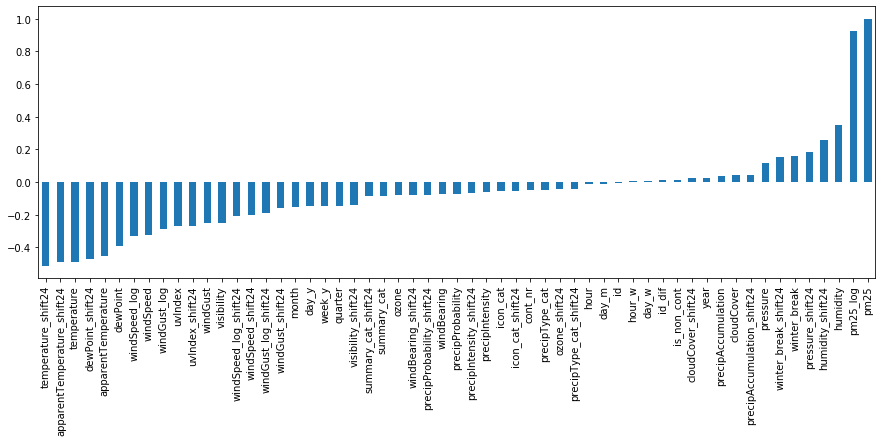

In [8]:
df.corr().pm25.sort_values().plot(kind='bar', figsize=(15,5));

### Analiza zmiennych ciągłych - szukanie kandydatów do logarytmizacji

In [9]:
to_check = 'pm25'
train[to_check].describe()

count    38952.000000
mean        24.989275
std         16.685422
min          1.308800
25%         13.405969
50%         20.366304
75%         31.549500
max        187.930147
Name: pm25, dtype: float64

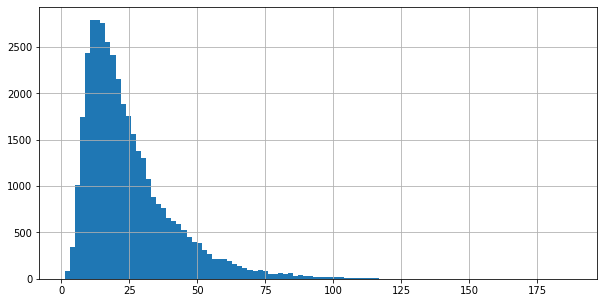

In [10]:
train[to_check].hist(bins=100, figsize=(10,5));

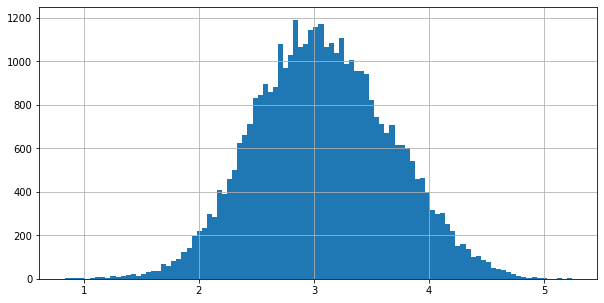

In [11]:
add = 1
np.log(train[ train[to_check]>0 ][to_check]+add).hist(bins=100, figsize=(10,5));

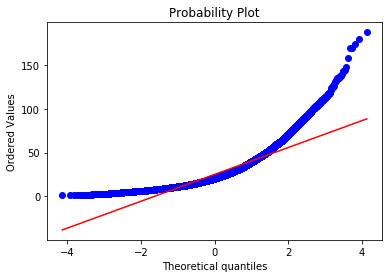

In [12]:
stats.probplot(train[to_check], dist="norm", plot=pylab)
pylab.show()

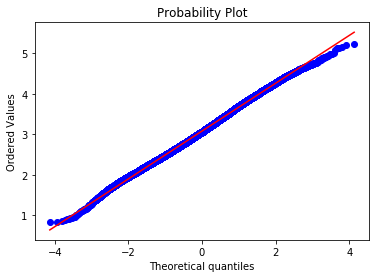

In [13]:
stats.probplot(np.log( train[train[to_check]>0][to_check]+add ), dist="norm", plot=pylab)
pylab.show()

### Analiza zbioru testowego - gdzie jest zlokalizowany, czy jest jednorodny itp

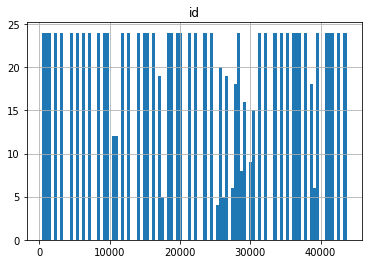

In [14]:
# wizualizacja rozrzucenia zbioru testowego 
pd.read_hdf('test_warsaw.h5').hist('id', bins=100);

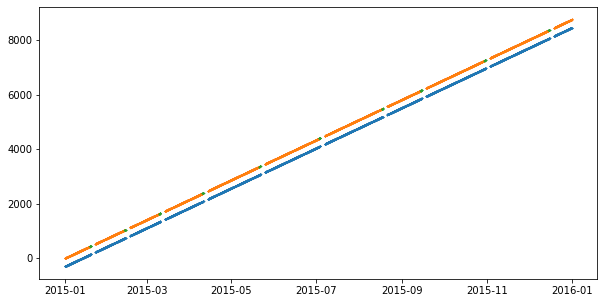

In [15]:
plt.figure(figsize=(10,5))

date_start = '2015-01-01'
date_stop = '2016-01-01'

df_ = df.loc[(df.date > date_start) & 
             (df.date < date_stop)]
plt.plot_date(df_.date, df_['id']-300, markersize=.5) # -300 odpowiada za rozsunięcie wykresów do wizualizacji

df_ = train.loc[(train.date > date_start) & 
                (train.date < date_stop)]
plt.plot_date(df_.date, df_['id'], markersize=.5)

df_ = test.loc[(test.date > date_start) & 
               (test.date < date_stop)]
plt.plot_date(df_.date, df_['id'], markersize=.5)

plt.show;

In [16]:
print(df['is_non_cont'].value_counts())
df.loc[df['is_non_cont']]['d_time'].describe()

False    40102
True        50
Name: is_non_cont, dtype: int64


count                 49
mean     3 days 01:00:00
std      0 days 00:00:00
min      3 days 01:00:00
25%      3 days 01:00:00
50%      3 days 01:00:00
75%      3 days 01:00:00
max      3 days 01:00:00
Name: d_time, dtype: object

### moje przemyslenia zanim Vladimir podał na Slacku klucz powstania zbioru test
różnice w 'id' zwykle różnią się o 1

w 49 przypadkach róznią się o 73 (3 doby + 1, pomiary co godzinę)

w datach różnią się o 3 doby

odstępy między lukami nie są równe

około 10 luk rocznie

godzina się przesuwa o 1:00 - ok. 10 powtórzeń (9-11), jakiś cykl?

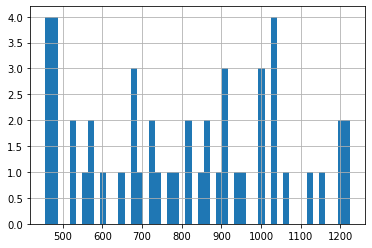

In [17]:
#długość "paczek" train-test-buffor
df.shift(1).loc[df['is_non_cont']].cont_nr.hist(bins=50);

### W większości sytuacji obrabiałem dane w ramach "paczek" a nie jako train i test w całości

### 5 kolejnych godzin (2 ostatnie z poprzedniej paczki, pierwsze 3 z nowej)

In [18]:
show_columns = ['date', 'id', 'pm25', 'is_non_cont', 'id_dif', 'd_time', 'cont_nr']

In [19]:
df.shift(2).loc[df['is_non_cont']][show_columns][:5]

,date,id,pm25,is_non_cont,id_dif,d_time,cont_nr
0,NaT,NaN,NaN,NaN,NaN,NaT,NaN
456,2015-01-19 22:00:00,454.0,NaN,False,1.0,01:00:00,455.0
984,2015-02-13 22:00:00,1054.0,NaN,False,1.0,01:00:00,527.0
1512,2015-03-10 22:00:00,1654.0,NaN,False,1.0,01:00:00,527.0
2184,2015-04-10 22:00:00,2398.0,NaN,False,1.0,01:00:00,671.0


In [20]:
df.shift(1).loc[df['is_non_cont']][show_columns][:5]

,date,id,pm25,is_non_cont,id_dif,d_time,cont_nr
0,NaT,NaN,NaN,NaN,NaN,NaT,NaN
456,2015-01-19 23:00:00,455.0,NaN,False,1.0,01:00:00,456.0
984,2015-02-13 23:00:00,1055.0,NaN,False,1.0,01:00:00,528.0
1512,2015-03-10 23:00:00,1655.0,NaN,False,1.0,01:00:00,528.0
2184,2015-04-10 23:00:00,2399.0,NaN,False,1.0,01:00:00,672.0


In [21]:
df.shift(0).loc[df['is_non_cont']][show_columns][:5]

,date,id,pm25,is_non_cont,id_dif,d_time,cont_nr
0,2015-01-01,0,51.5034,True,0,NaT,1
456,2015-01-23,528,21.4316,True,73,3 days 01:00:00,1
984,2015-02-17,1128,15.6238,True,73,3 days 01:00:00,1
1512,2015-03-14,1728,29.4480,True,73,3 days 01:00:00,1
2184,2015-04-14,2472,10.7158,True,73,3 days 01:00:00,1


In [22]:
df.shift(-1).loc[df['is_non_cont']][show_columns][:5]

,date,id,pm25,is_non_cont,id_dif,d_time,cont_nr
0,2015-01-01 01:00:00,1.0,71.8204,False,1.0,01:00:00,2.0
456,2015-01-23 01:00:00,529.0,24.0492,False,1.0,01:00:00,2.0
984,2015-02-17 01:00:00,1129.0,13.5788,False,1.0,01:00:00,2.0
1512,2015-03-14 01:00:00,1729.0,27.1576,False,1.0,01:00:00,2.0
2184,2015-04-14 01:00:00,2473.0,10.5522,False,1.0,01:00:00,2.0


In [23]:
df.shift(-2).loc[df['is_non_cont']][show_columns][:5]

,date,id,pm25,is_non_cont,id_dif,d_time,cont_nr
0,2015-01-01 02:00:00,2.0,42.6996,False,1.0,01:00:00,3.0
456,2015-01-23 02:00:00,530.0,20.6136,False,1.0,01:00:00,3.0
984,2015-02-17 02:00:00,1130.0,14.2332,False,1.0,01:00:00,3.0
1512,2015-03-14 02:00:00,1730.0,25.5216,False,1.0,01:00:00,3.0
2184,2015-04-14 02:00:00,2474.0,9.3252,False,1.0,01:00:00,3.0


In [24]:
train[train.columns].describe()

,apparentTemperature,cloudCover,dewPoint,humidity,id,ozone,pm25,precipAccumulation,precipIntensity,precipProbability,...,visibility_shift24,windBearing_shift24,windGust_shift24,windSpeed_shift24,winter_break_shift24,windSpeed_log_shift24,windGust_log_shift24,icon_cat_shift24,precipType_cat_shift24,summary_cat_shift24
count,38952.000000,38952.000000,38952.000000,38952.000000,38952.000000,11855.000000,38952.000000,38952.000000,38952.000000,38952.000000,...,37752.000000,37752.000000,37752.000000,37752.000000,37752.000000,37686.000000,37690.000000,38928.000000,38928.000000,38928.000000
mean,48.311787,0.577618,41.221003,0.725441,21826.169131,317.468528,24.989275,0.000407,0.000903,0.021797,...,6.893445,194.448003,10.337415,7.573967,0.030515,2.486153,2.367639,2.342607,-0.866523,2.330636
std,18.780260,0.325184,12.825984,0.179451,12573.916139,39.598399,16.685422,0.005907,0.005867,0.094021,...,2.215991,93.847816,6.987976,3.927510,0.172002,0.305217,0.543537,1.929524,0.381397,2.364500
min,-11.330000,0.000000,-9.650000,0.120000,0.000000,224.200000,1.308800,0.000000,0.000000,0.000000,...,0.122000,0.000000,0.000000,0.000000,0.000000,1.613430,0.703098,-1.000000,-1.000000,-1.000000
25%,32.997500,0.250000,32.057500,0.600000,10985.750000,288.600000,13.405969,0.000000,0.000000,0.000000,...,6.215000,115.000000,5.330000,4.690000,0.000000,2.271094,1.996060,0.000000,-1.000000,0.000000
50%,48.340000,0.725000,41.420000,0.760000,21875.500000,314.100000,20.366304,0.000000,0.000000,0.000000,...,6.216000,210.000000,8.670000,6.930000,0.000000,2.479056,2.370244,2.000000,-1.000000,2.000000
75%,63.462500,0.870000,51.470000,0.870000,32669.250000,339.900000,31.549500,0.000000,0.000000,0.000000,...,10.000000,270.000000,13.380000,9.870000,0.000000,2.699346,2.734368,4.000000,-1.000000,4.000000
max,96.810000,1.000000,70.480000,1.000000,43655.000000,484.600000,187.930147,0.275400,0.272100,0.970000,...,10.000000,359.000000,51.640000,38.780000,1.000000,3.779177,3.982295,9.000000,2.000000,27.000000


In [25]:
test[test.columns].describe()

,apparentTemperature,cloudCover,dewPoint,humidity,id,ozone,pm25,precipAccumulation,precipIntensity,precipProbability,...,visibility_shift24,windBearing_shift24,windGust_shift24,windSpeed_shift24,winter_break_shift24,windSpeed_log_shift24,windGust_log_shift24,icon_cat_shift24,precipType_cat_shift24,summary_cat_shift24
count,0.0,0.0,0.0,0.0,1200.000000,0.0,0.0,0.0,0.0,0.0,...,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1197.000000,1197.000000,1200.000000,1200.000000,1200.000000
mean,NaN,NaN,NaN,NaN,22239.820000,NaN,NaN,NaN,NaN,NaN,...,6.943941,200.732500,9.492825,6.661058,0.060000,2.403480,2.256175,2.508333,-0.830833,2.510833
std,NaN,NaN,NaN,NaN,13077.033337,NaN,NaN,NaN,NaN,NaN,...,2.302254,90.235459,7.371526,3.975583,0.237586,0.327623,0.612688,1.942440,0.415162,2.427920
min,NaN,NaN,NaN,NaN,432.000000,NaN,NaN,NaN,NaN,NaN,...,0.182000,0.000000,0.000000,0.000000,0.000000,1.613430,0.703098,-1.000000,-1.000000,-1.000000
25%,NaN,NaN,NaN,NaN,10811.750000,NaN,NaN,NaN,NaN,NaN,...,6.215000,130.000000,4.000000,3.407500,0.000000,2.131797,1.791759,1.000000,-1.000000,1.000000
50%,NaN,NaN,NaN,NaN,21779.500000,NaN,NaN,NaN,NaN,NaN,...,6.216000,211.000000,7.010000,5.840000,0.000000,2.385086,2.198335,3.000000,-1.000000,2.000000
75%,NaN,NaN,NaN,NaN,34187.250000,NaN,NaN,NaN,NaN,NaN,...,10.000000,273.000000,13.000000,9.107500,0.000000,2.648300,2.708050,4.000000,-1.000000,4.000000
max,NaN,NaN,NaN,NaN,43679.000000,NaN,NaN,NaN,NaN,NaN,...,10.000000,359.000000,37.200000,22.930000,1.000000,3.329701,3.668677,7.000000,1.000000,19.000000


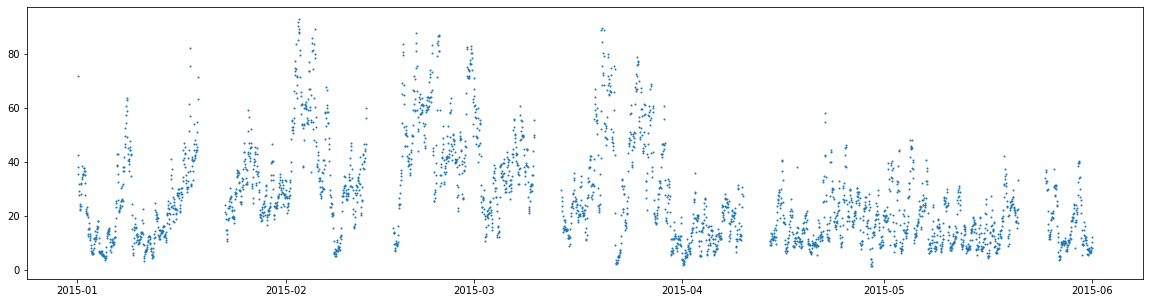

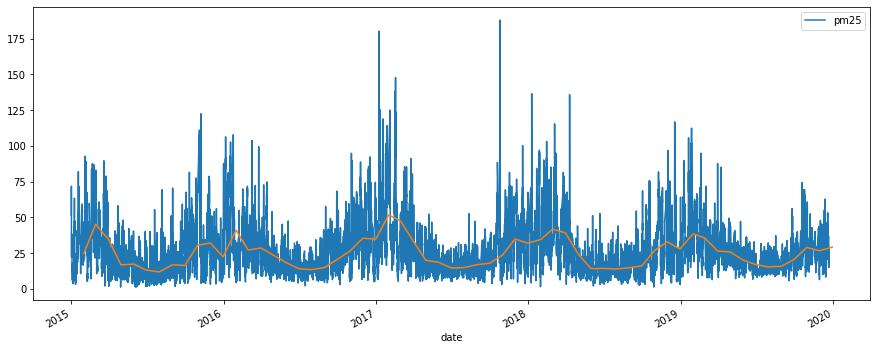

In [26]:
date_start = '2015-01-01'
date_stop = '2015-06-01'

train_ = train.loc[(train.date > date_start) & 
             (train.date < date_stop)]
test_ = test.loc[(test.date > date_start) & 
             (test.date < date_stop)]
plt.figure(figsize=(20,5))
plt.plot_date(train_.date, train_['pm25'], markersize=1);
# plt.plot(train_.date, train_['pm25']);
plt.plot_date(test_.date, test_['pm25'], markersize=1);
train.plot(y='pm25', x='date', figsize=(20,10));

train_date = train.set_index('date')
train_date['pm25'].resample('M').mean().plot(figsize=(15, 6));

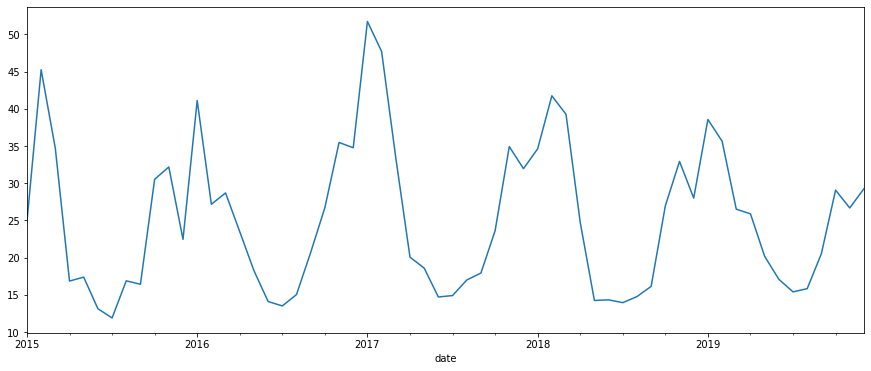

In [27]:
# średnia miesięczna
plt.figure(figsize=(15, 6))
train_date['pm25'].resample('M').mean().plot(figsize=(15, 6));

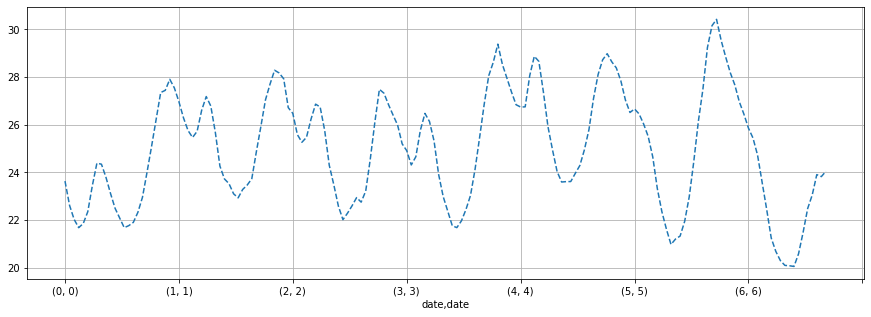

In [28]:
#dzień tygodnia i godzina
by_week_hour = train.groupby([train.set_index('date').index.dayofweek, 
                         train.set_index('date').index.hour]).mean()['pm25']
by_week_hour.plot(figsize=(15, 5), style=['--', ':', '-', '-.']).grid(axis='both');

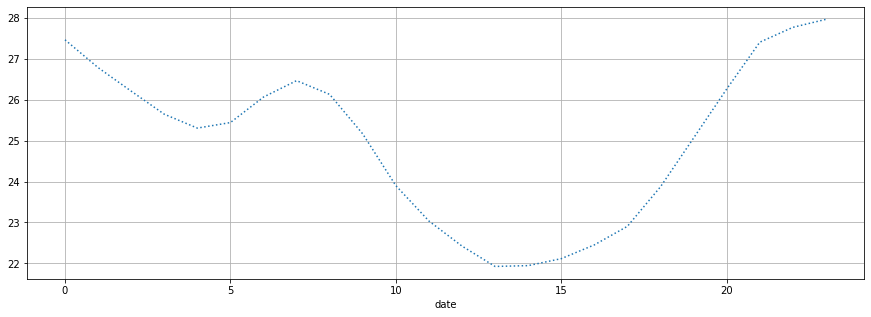

In [29]:
# godzina
by_hour = train.groupby(train.set_index('date').index.hour).mean()['pm25']
by_hour.plot(figsize=(15, 5), style=[':', '--', '-', '-.']).grid(axis='both');

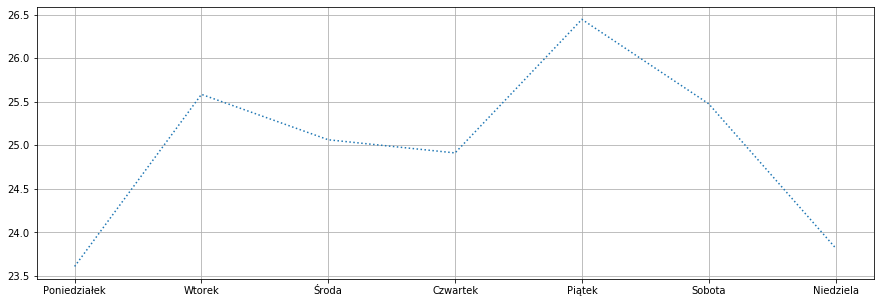

In [30]:
# dzień tygodnia
by_day_of_week = train.groupby(train.set_index('date').index.dayofweek).mean()['pm25']
by_day_of_week.index = ['Poniedziałek', 'Wtorek', 'Środa', 'Czwartek', 'Piątek', 'Sobota', 'Niedziela']
by_day_of_week.plot(figsize=(15, 5), style=[':', '--', '-', '-.']).grid(axis='both');

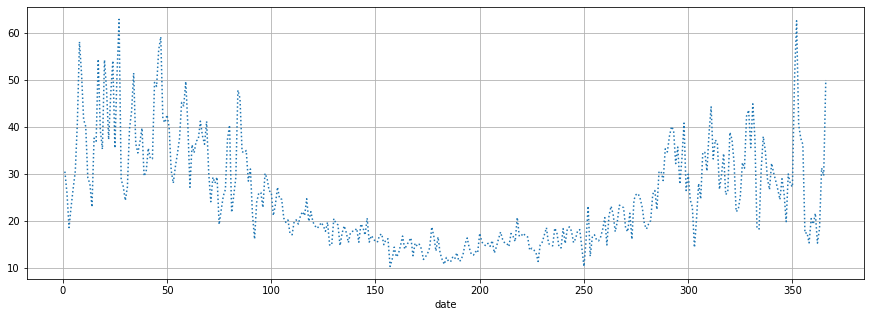

In [31]:
# dzień roku
by_day_of_year = train.groupby(train.set_index('date').index.dayofyear).mean()['pm25']
by_day_of_year.plot(figsize=(15, 5), style=[':', '--', '-', '-.']).grid(axis='both');

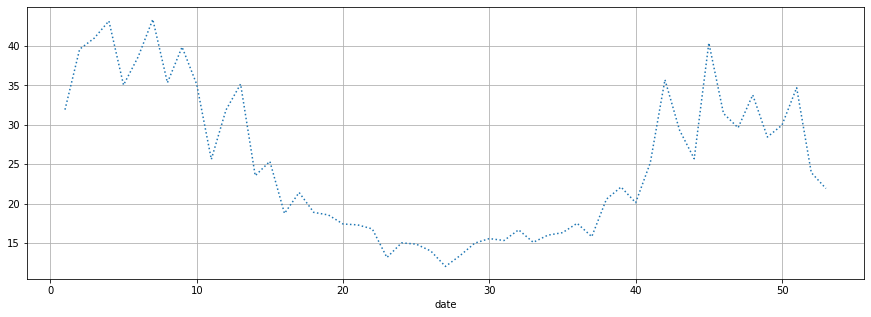

In [32]:
# tydzień roku
by_week_of_year = train.groupby(train.set_index('date').index.week).mean()['pm25']
by_week_of_year.plot(figsize=(15, 5), style=[':', '--', '-', '-.']).grid(axis='both');

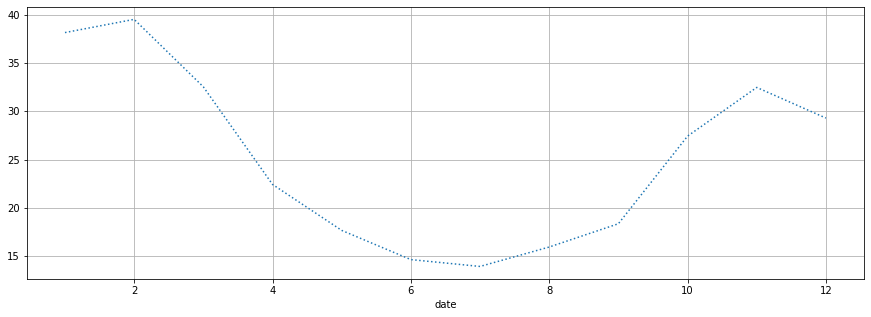

In [33]:
# miesiąc
by_month = train.groupby(train.set_index('date').index.month).mean()['pm25']
by_month.plot(figsize=(15, 5), style=[':', '--', '-', '-.']).grid(axis='both');

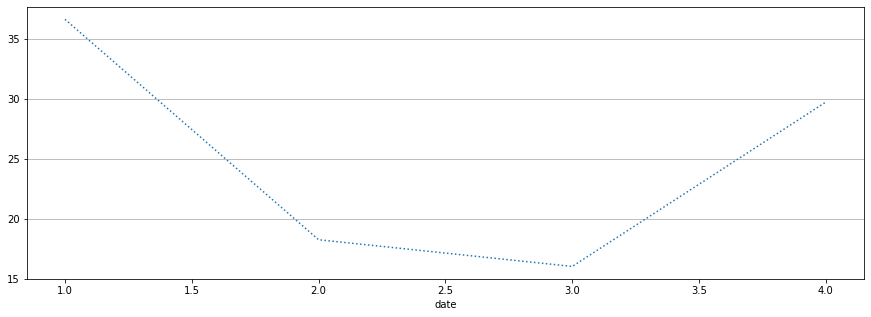

In [34]:
# kwartał
by_quarter = train.groupby(train.set_index('date').index.quarter).mean()['pm25']
by_quarter.plot(figsize=(15, 5), style=[':', '--', '-', '-.']).grid(axis='y');

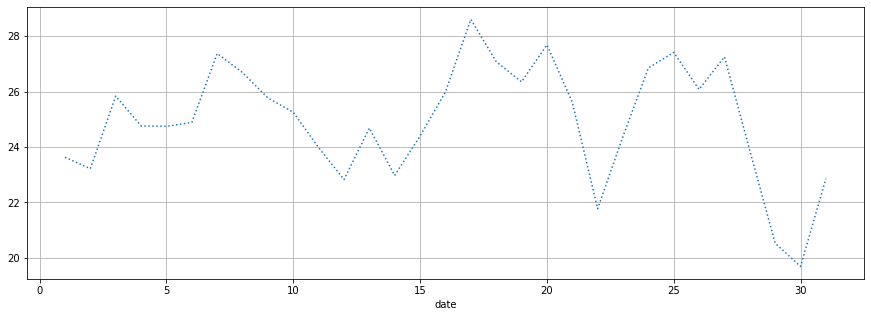

In [35]:
# dzień miesiąca - biały szum
by_month = train.groupby(train.set_index('date').index.day).mean()['pm25']
by_month.plot(figsize=(15, 5), style=[':', '--', '-', '-.']).grid(axis='both');

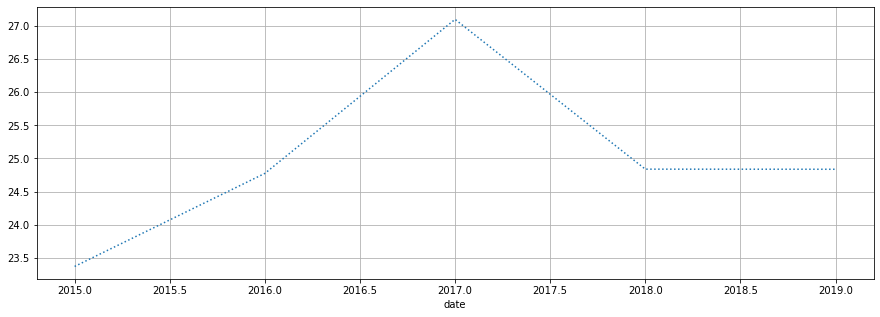

In [36]:
# rok
by_year = train.groupby(train.set_index('date').index.year).mean()['pm25']
by_year.plot(figsize=(15, 5), style=[':', '--', '-', '-.']).grid(axis='both');

### Dane mają cykl dobowy, tygodniowy i roczny

### basic model

In [37]:
# feats = ['id']  ##cokolwiek na początek
# X_train = train[feats].values
# y_train = train['pm25'].values
# X_test  = test[feats].values


# model = DummyRegressor()
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)

# test['pm25'] = y_pred
# test[ ['id', 'pm25'] ].to_csv('model_dummy.csv', index=False)

### pomysły wstępne

model prognozujący 24 pomiary do przodu

model prognozujący jeden pomiar na 24h do przodu - opuszcza ostatnią dobę z train

24 modele prognozujące po jednym pomiarze 1-24h do przodu - używa więcej danych

ilość dni bez opadów

ilość dni bez wiatru

dni wolne od pracy w Warszawie

dwa modele - jeden klasyczny z danymi datetime, drugi timeseries forecasting z pozostałymi kolumnami, ?jak je połączyć?

suma opady z ostatnich 5-7 dni

### lokalne train i test używane do walidacji modelu

In [37]:
def run_model_basic(train, test, feats, model, params, plot=(True, True), csv=None, scoring=rmse, y_log=False):
    
    X = train[feats].values
    if y_log:
        y = (train['pm25_log'].values).astype(np.float64)
    else:
        y = (train['pm25'].values).astype(np.float64)

    model = model(**params)
    model.fit(X, y)

    X_test = test[feats].values
    y_test = (test['pm25'].values).astype(np.float64)
    y_pred = (model.predict(X_test)).astype(np.float64)
    if y_log:
        y_pred = np.exp(y_pred)-1

    score = "rmse, mae, r2", rmse(y_test, y_pred), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
    
#     if csv:
#         test[ ['id', 'pm25'] ].to_csv(csv, index=False)
    
    if plot[0]:
        ax = plt.gca()
        better = scoring == r2_score   # R2 im większe tym lepsze, MAE, RMSE odwrotnie
        scoring_fn = make_scorer(scoring, greater_is_better=better)
        plot_learning_curve(model, X, y, random_state=123, shuffle=False, n_jobs=8, scoring=scoring_fn, ax=ax);
               
    if plot[1]:   
        plt.figure(figsize=(20,10))
        plt.scatter(np.arange(len(y_test)), y_test, label='real', s=3, c='blue');
        plt.scatter(np.arange(len(y_pred)), y_pred, label='pred', s=3, c='red');
        plt.legend()
        plt.show;
    
    return(score, model)

In [38]:
def run_model_cv(train, test, feats, model, params, cv=None, plot=(True, True), csv=None, verbose=True, \
                 scoring=rmse, y_log=False):
    
    X = train[feats].values    
    if y_log:
        y = (train['pm25_log'].values).astype(np.float64)
    else:
        y = (train['pm25'].values).astype(np.float64)        

    model = model(**params)

    if cv:   
        scores = []
        for train_idx, test_idx in cv.split(X, y):
            X_fold_train, X_fold_test = X[train_idx], X[test_idx]
            y_fold_train, y_fold_test = y[train_idx], y[test_idx]
            model.fit(X_fold_train, y_fold_train)
            y_fold_pred = (model.predict(X_fold_test))
            if y_log:
                y_fold_test = np.exp(y_fold_test)-1
                y_fold_pred = np.exp(y_fold_pred)-1
            score = "rmse, mae, r2", rmse(y_fold_test, y_fold_pred), mean_absolute_error(y_fold_test, y_fold_pred), \
                                        r2_score(y_fold_test, y_fold_pred)
            scores.append( score )
            if verbose: print(scores[-1], X_fold_train.shape[0], X_fold_test.shape[0])
    else:
        model.fit(X, y)
        
    X_test = test[feats].values
    y_test = (test['pm25'].values).astype(np.float64)
    y_pred = (model.predict(X_test)).astype(np.float64)
    if y_log:
        y_pred = np.exp(y_pred)-1
        
    score = "rmse, mae, r2", rmse(y_test, y_pred), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
    
#     if csv:
#         test[ ['id', 'pm25'] ].to_csv(csv, index=False)
    
    if plot[0]:
        ax = plt.gca()
        better = scoring == r2_score  # R2 im większe tym lepsze, MAE, RMSE odwrotnie
        scoring_fn = make_scorer(scoring, greater_is_better=better)        
        plot_learning_curve(model, X, y, random_state=123, shuffle=False, n_jobs=8, scoring=scoring_fn, ax=ax);
   
    if plot[1]:   
        plt.figure(figsize=(20,10))
        plt.scatter(np.arange(len(y_test)), y_test, label='real', s=3, c='blue');
        plt.scatter(np.arange(len(y_pred)), y_pred, label='pred', s=3, c='red');
        plt.legend()
        plt.show;
        
    return(score, model)

('rmse, mae, r2', 1.450732160679823, 1.0674993681907654, 0.9756384114620492)
Wall time: 6.4 s


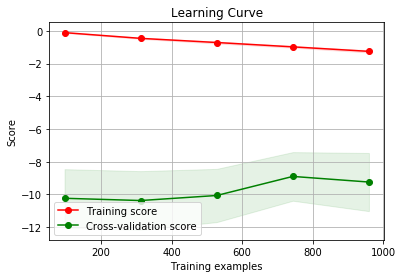

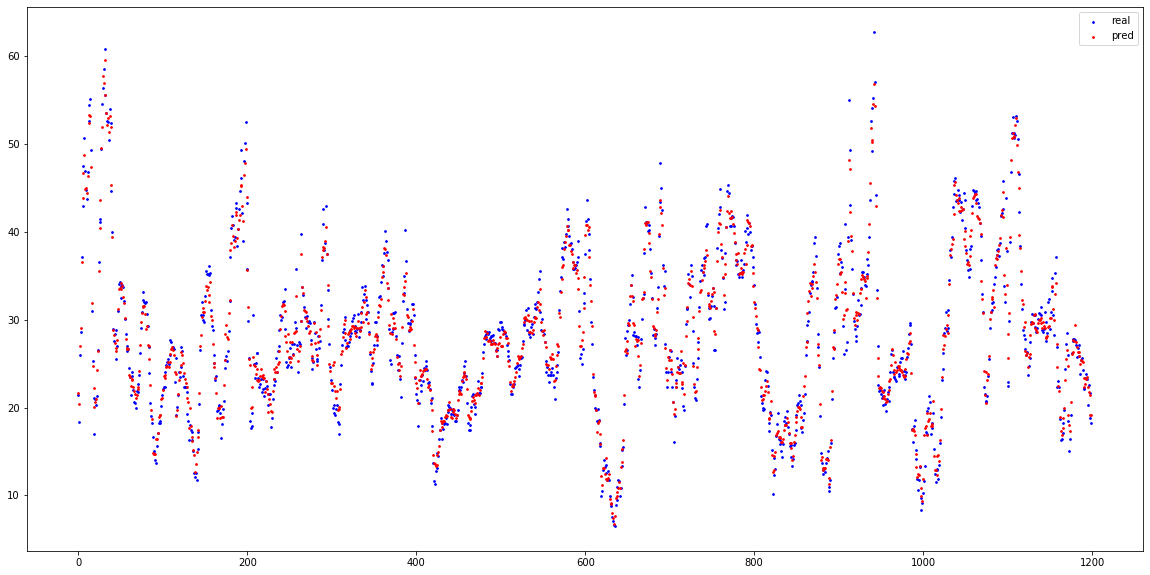

In [40]:
%%time
# ?full overfit? - train and test are the same
feats = num_feats
feats = [feat for feat in feats if feat not in black_list_feats]
with_params = {
    'train'  : train.iloc[-1200:],
    'test'   : train.iloc[-1200:],
    'feats'  : feats,
    'model'  : xgb.XGBRegressor,
    'params' : {'n_jobs': 8,
               'random_state': 123,
               'objective': 'reg:squarederror',
               'max_depth': 5,
               'subsample': 0.95},
    'plot'   : (True, True),
    'csv'    : None,
    'scoring': rmse,         #rmse mean_absolute_error r2_score
    'y_log'  : False
}
score, model = run_model_basic(**with_params)
print(score)

('rmse, mae, r2', 8.072572270329426, 6.169765533884797, 0.24568106493027164)
Wall time: 13.9 s


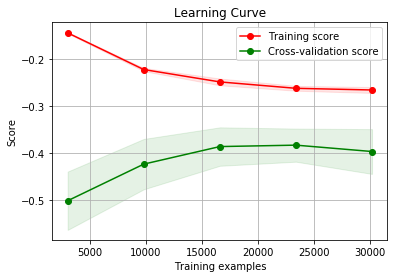

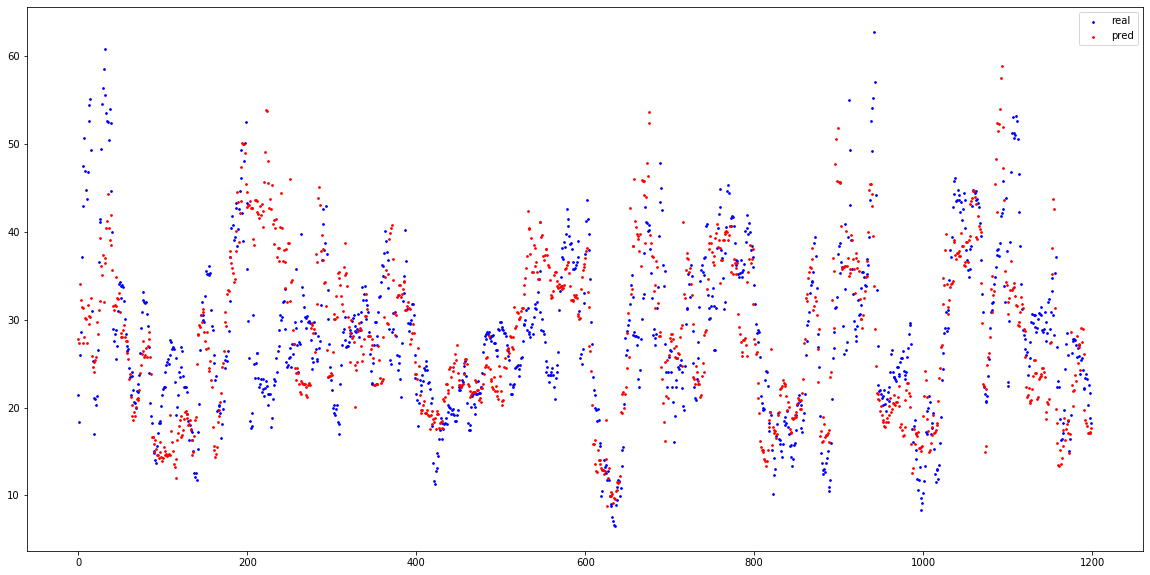

In [41]:
%%time
#all feats (incl time_feats), XGBRegressor, no cv
feats = num_feats
feats = [feat for feat in feats if feat not in black_list_feats]
with_params = {
    'train'  : train.iloc[:-1200],
    'test'   : train.iloc[-1200:],
    'feats'  : feats,
    'model'  : xgb.XGBRegressor,
    'params' : {'n_jobs': 8,
               'random_state': 123,
               'objective': 'reg:squarederror',
               'max_depth': 5,
               'subsample': 0.95},
    'plot'   : (True, True),
    'csv'    : None,
    'scoring': rmse,         #rmse mean_absolute_error r2_score
    'y_log'  : True
}
score, model = run_model_basic(**with_params)
print(score)

('rmse, mae, r2', 10.554741744231391, 8.313959892812724, -0.2895148529054814)
Wall time: 18.5 s


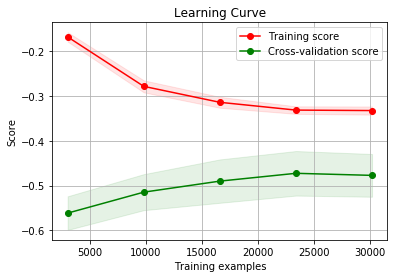

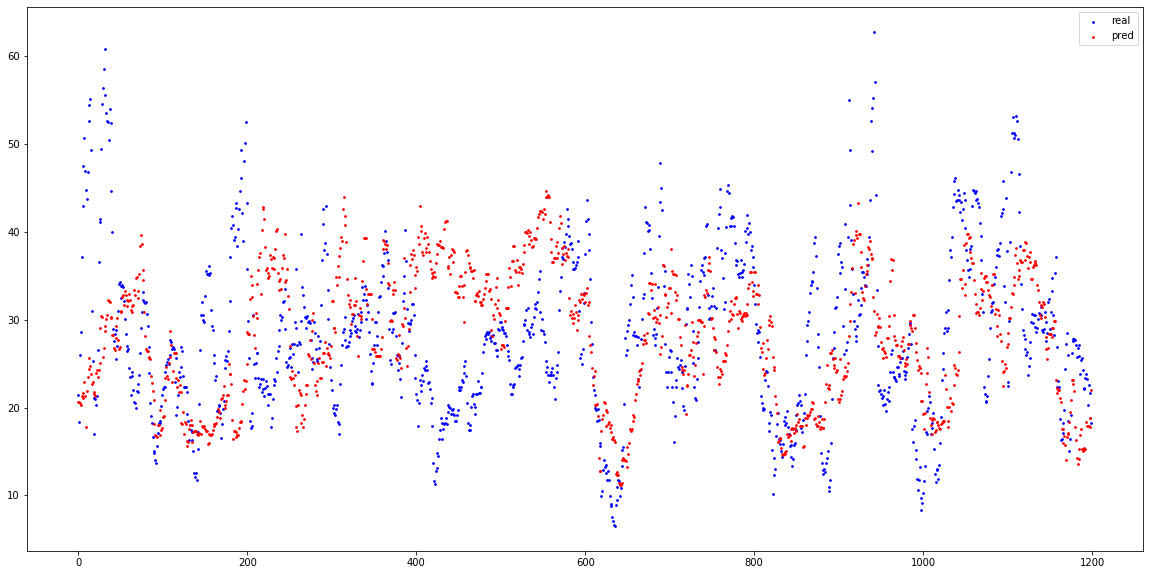

In [42]:
%%time
#time_feats XGBRegressor no CV
feats = time_feats + shift_feats
feats = [feat for feat in feats if feat not in black_list_feats]
with_params = {
    'train'  : train.iloc[:-1200],
    'test'   : train.iloc[-1200:],
    'feats'  : feats,
    'model'  : xgb.XGBRegressor,
    'params' : {'n_jobs': 8,
                'random_state': 123,
                'objective': 'reg:squarederror',
                'max_depth': 5,
                'subsample': 0.95},
    'plot'   : (True, True),
    'csv'    : None,
    'scoring': rmse,         #rmse mean_absolute_error r2_score
    'y_log'  : True
}
score, model = run_model_basic(**with_params)
print(score) 
# ('rmse, mae, r2', 12.72927594691179, 9.971830559469426, -0.8755926779316716) time_feats
# ('rmse, mae, r2', 10.738824734957575, 8.592406217800432, -0.3348874037024412) time_feats + shift_feats

('rmse, mae, r2', 11.489769516610451, 8.433927996137857, 0.5646613614408418) 28314 9438
('rmse, mae, r2', 11.518564130578214, 7.667602087844833, 0.6382355682724268) 28314 9438
('rmse, mae, r2', 8.862413895274443, 6.104170388046711, 0.6787323204398332) 28314 9438
('rmse, mae, r2', 12.16631121634923, 8.131871523465088, 0.32081052252905784) 28314 9438
('rmse, mae, r2', 8.27361643150858, 6.505451629797617, 0.2076411883805095)
Wall time: 10.9 s


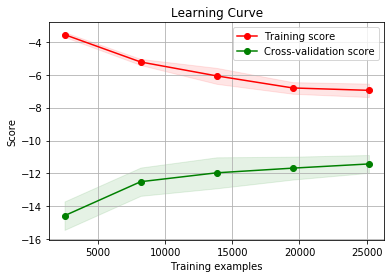

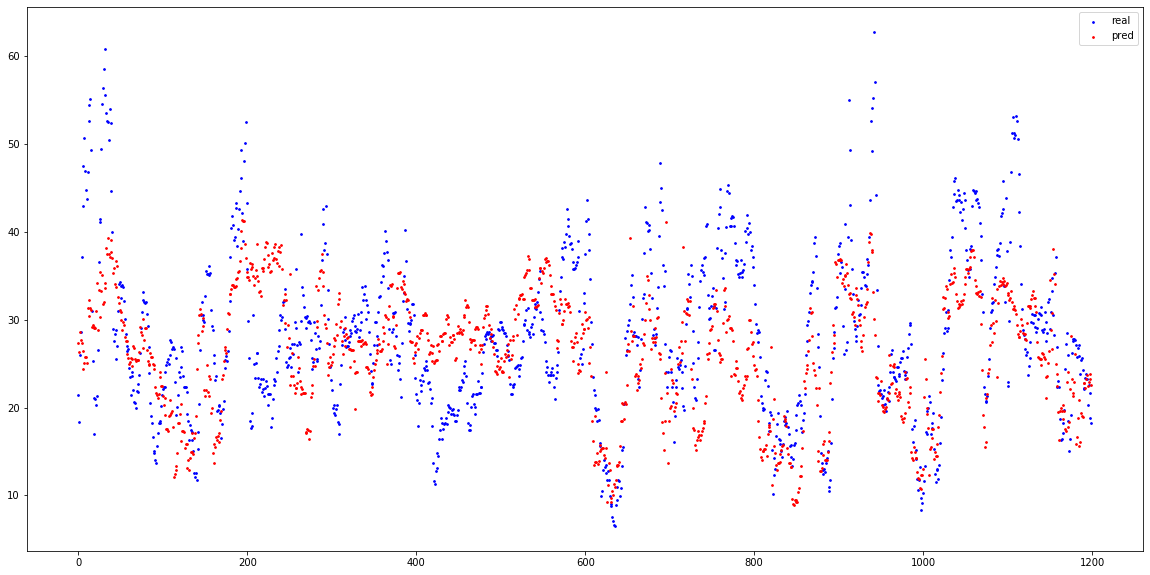

In [43]:
%%time
#KFold, all feats, XGBRegressor
feats = num_feats
feats = [feat for feat in feats if feat not in black_list_feats]
with_params = {
    'train' : train.iloc[:-1200],
    'test'  : train.iloc[-1200:],
    'feats' : feats,
    'model' : xgb.XGBRegressor,
    'params': {'n_jobs': 8,
               'random_state': 123,
               'objective': 'reg:squarederror',
               'max_depth': 5,
               'subsample': 0.95},
    'cv'    : KFold(n_splits=4, shuffle=False, random_state=123),
    'plot'  : (True, True),
    'csv'   : None,
    'scoring': rmse,         #rmse mean_absolute_error r2_score
    'y_log'  : False
}
score, model = run_model_cv(**with_params)
print(score)

('rmse, mae, r2', 14.470307907007626, 10.414343189255867, 0.3095056556692338) 28314 9438
('rmse, mae, r2', 15.296782088333883, 9.78223664538776, 0.361987282001751) 28314 9438
('rmse, mae, r2', 12.311329996414056, 8.192994534459665, 0.3800267892764695) 28314 9438
('rmse, mae, r2', 12.78199771424016, 8.733432601578729, 0.2503292318528769) 28314 9438
('rmse, mae, r2', 9.825288031131487, 7.652858337631934, -0.11743355240862807)
Wall time: 13.7 s


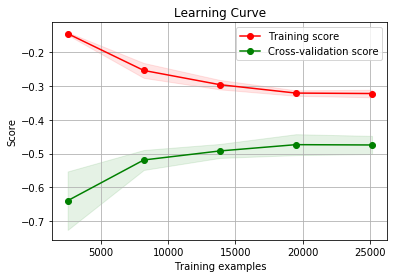

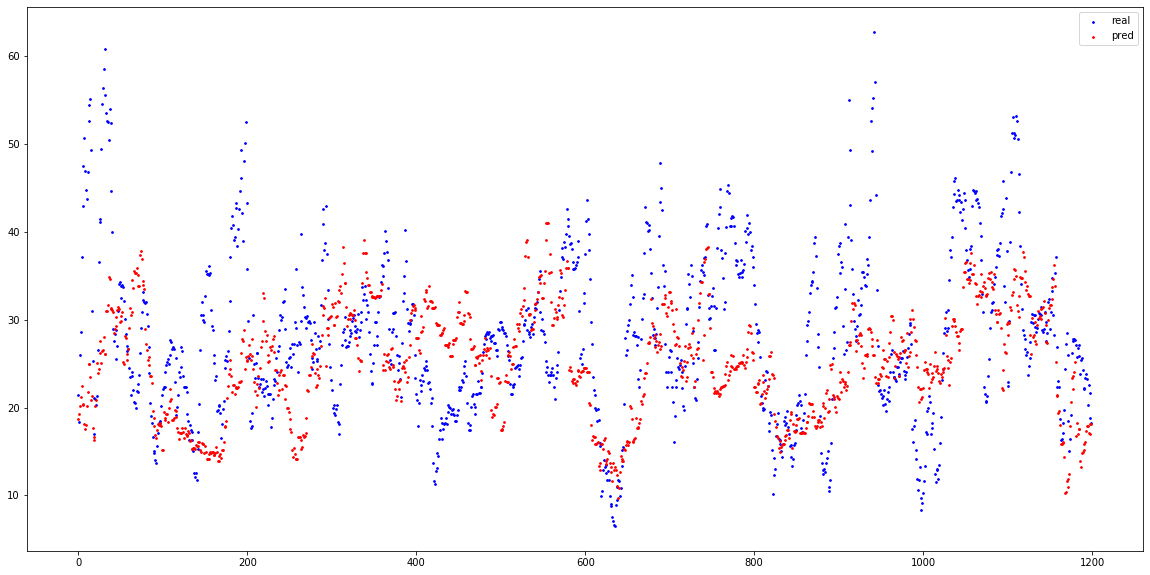

In [44]:
%%time
#KFold, time feats, XGBRegressor
feats = time_feats + shift_feats
feats = [feat for feat in feats if feat not in black_list_feats]
with_params = {
    'train' : train.iloc[:-1200],
    'test'  : train.iloc[-1200:],
    'feats' : feats,
    'model' : xgb.XGBRegressor,
    'params': {'n_jobs': 8,
               'random_state': 123,
               'objective': 'reg:squarederror',
               'max_depth': 5,
               'subsample': 0.95},
    'cv'    : KFold(n_splits=4, shuffle=False, random_state=123),
    'plot'  : (True, True),
    'csv'   : None,
    'scoring': rmse,         #rmse mean_absolute_error r2_score
    'y_log'  : True
}
score, model = run_model_cv(**with_params)
print(score)

# ('rmse, mae, r2', 10.675855680680737, 8.514865924363308, -0.31927859010069803)
# ('rmse, mae, r2', 10.311265881050621, 8.25036459713463, -0.23070820803949266)

('rmse, mae, r2', 22.19145843751036, 17.200343819473932, -0.3092301743453525) 952 920
('rmse, mae, r2', 13.55069865232363, 11.018205921442611, -1.254969153516575) 1872 920
('rmse, mae, r2', 6.972571666984973, 5.684523384290777, 0.1002405461147663) 2792 920
('rmse, mae, r2', 7.201805949613969, 4.6076238883275575, 0.1637826902568018) 3712 920
('rmse, mae, r2', 7.711332254757465, 5.77451479639647, 0.28520189403811547) 4632 920
('rmse, mae, r2', 18.23185732606807, 13.564697296572147, -0.46034170664743956) 5552 920
('rmse, mae, r2', 13.76573671630388, 9.810638901158207, 0.5732835788973822) 6472 920
('rmse, mae, r2', 15.104728661870498, 10.774402879040721, 0.536834933233599) 7392 920
('rmse, mae, r2', 9.836129568182427, 7.64277243193753, 0.37207859627932294) 8312 920
('rmse, mae, r2', 12.25601453345542, 9.224415394247735, 0.2286280100974757) 9232 920
('rmse, mae, r2', 6.180033497786504, 4.465411653029534, 0.222246095501353) 10152 920
('rmse, mae, r2', 4.975660688474183, 3.9069186254071773, 0

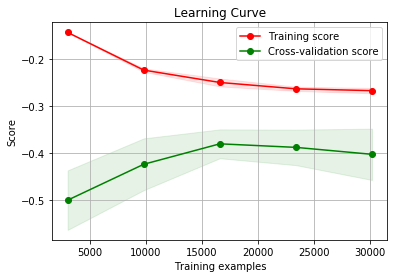

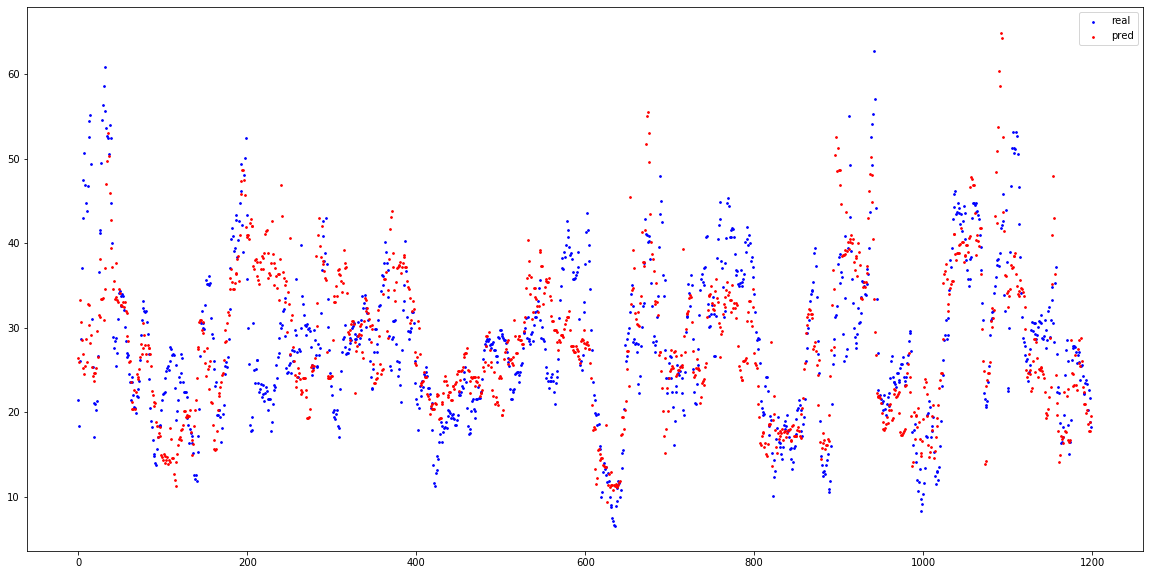

In [46]:
%%time
#TS split, all feats, XGBRegressor
feats = num_feats
exclude = ['icon_cat', 'precipType_cat', 'summary_cat', 'windGust_log', 'windSpeed_log']
feats = [feat for feat in feats if feat not in black_list_feats]
feats = [feat for feat in feats if feat not in exclude]
with_params = {
    'train' : train.iloc[:-1200],
    'test'  : train.iloc[-1200:],
    'feats' : feats,
    'model' : xgb.XGBRegressor,
    'params': {'n_jobs': 8,
               'random_state': 123,
               'objective': 'reg:squarederror',
               'max_depth': 5,
               'subsample': 0.95},
    'cv'    : TimeSeriesSplit(n_splits=40, max_train_size=None),
    'plot'  : (True, True),
    'csv'   : None,
    'scoring': rmse,         #rmse mean_absolute_error r2_score
    'y_log'  : True
}
score, model = run_model_cv(**with_params)
print(score)

('rmse, mae, r2', 15.662504732555766, 9.822241668722933, -0.024081608708511615) 3432 3432
('rmse, mae, r2', 18.165966268764315, 13.38492877065725, -0.19077115054671134) 6864 3432
('rmse, mae, r2', 7.605767808115123, 5.635509746708618, 0.061679965697565176) 10296 3432
('rmse, mae, r2', 23.736269935338278, 16.73222786874226, -0.006079404109302855) 13728 3432
('rmse, mae, r2', 9.352219400082607, 6.482891780763729, 0.1416185378273055) 17160 3432
('rmse, mae, r2', 14.894567388425605, 10.497508648893367, 0.06792838003297763) 20592 3432
('rmse, mae, r2', 13.538482295606341, 9.47151796249692, 0.4508099221933305) 24024 3432
('rmse, mae, r2', 12.125727676385509, 8.51512929911093, 0.32331618721952815) 27456 3432
('rmse, mae, r2', 15.687927984028306, 11.078279903632538, 0.08703666046240088) 30888 3432
('rmse, mae, r2', 8.099749750447637, 5.246326390718274, 0.26249499817092825) 34320 3432
('rmse, mae, r2', 10.667551532840463, 8.354545147329645, -0.31722700305145524)
Wall time: 18.2 s


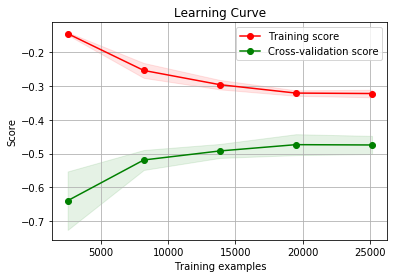

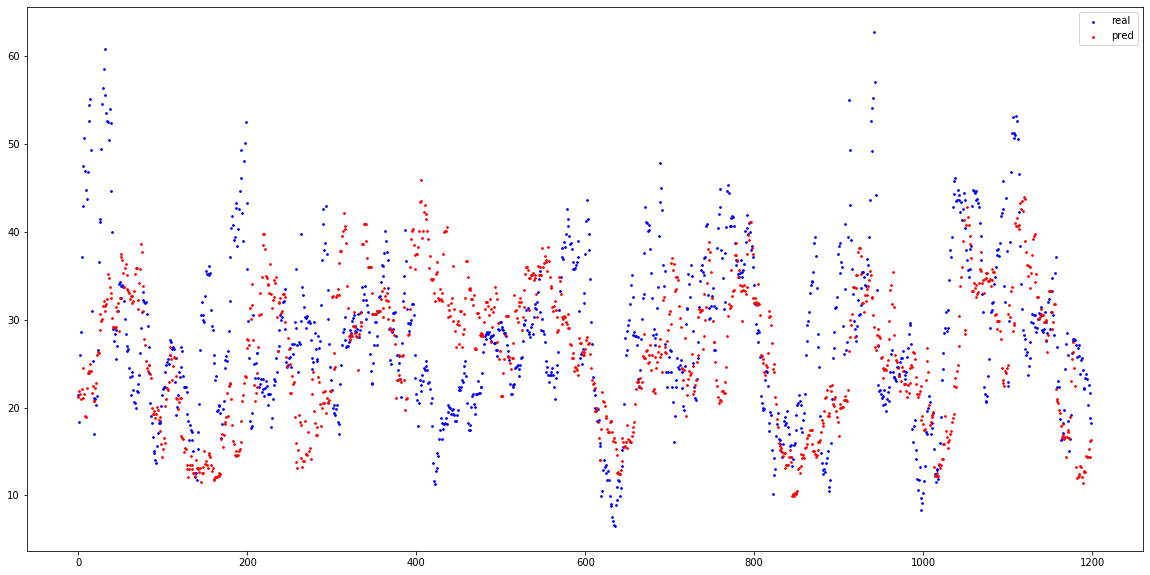

In [46]:
%%time
#TS split, time feats, XGBRegressor
feats = time_feats + shift_feats
feats = [feat for feat in feats if feat not in black_list_feats]
with_params = {
    'train' : train.iloc[:-1200],
    'test'  : train.iloc[-1200:],
    'feats' : feats,
    'model' : xgb.XGBRegressor,
    'params': {'n_jobs': 8,
               'random_state': 123,
               'objective': 'reg:squarederror',    #reg:squarederror reg:linear
               'max_depth': 5,
#                'eval_metric': rmse,        #mae
               'subsample': 0.95},
    'cv'    : TimeSeriesSplit(n_splits=10, max_train_size=None),
    'plot'  : (True, True),
    'csv'   : None,
    'scoring': rmse,         #rmse mean_absolute_error r2_score
    'y_log'  : True
}
score, model = run_model_cv(**with_params)
print(score)
# ('rmse, mae, r2', 10.821758800471072, 8.508603095583828, -0.35558522306431795)
# ('rmse, mae, r2', 10.340061361123386, 8.138225819061336, -0.2375916145471917) n_splits=20 y_log=true

In [39]:
def run_model_parts(train_parts, test_parts, feats, model, params, \
                    cv=None, folds=None, plot=None, csv=None, verbose=True, scoring=rmse,  y_log=False):
    
    X_train_all, y_train_all = pd.DataFrame(columns=feats).values, np.array([])
    X_test_all, y_test_all, y_pred_all = X_train_all.copy(), np.array([]), np.array([])    
    scores = []
    dates = []      # wykorzystywane przy plt.plot_date zamiast plt.scatter
    model = model(**params)
    
    for train, test in tqdm(zip(train_parts, test_parts)):
        
        X = train[feats].values
        if y_log:
            y = (train['pm25_log'].values).astype(np.float64)
        else:
            y = (train['pm25'].values).astype(np.float64)
        
        X_train = X[:-24]
        y_train = y[:-24]
        
        X_train_all = np.concatenate((X_train_all, X_train))
        y_train_all = np.concatenate((y_train_all, y_train))
        
        if cv:
            nr_folds = int((X_train.shape[0] / 24))
            if folds: nr_folds = folds
            cv_local = cv(n_splits=nr_folds)
            for train_idx, test_idx in cv_local.split(X_train, y_train):
                X_fold_train, X_fold_test = X_train[train_idx], X_train[test_idx]
                y_fold_train, y_fold_test = y_train[train_idx], y_train[test_idx]
                model.fit(X_fold_train, y_fold_train)               
        else:
            model.fit(X_train, y_train)

        X_test = X[-24:]
        y_test = y[-24:]
        
        if len(dates)==0:
            dates = train['date'][-24:]
        else:
            dates = np.concatenate((dates, train['date'][-24:]))
        y_pred = (model.predict(X_test)).astype(np.float64)
        
        if y_log:
            y_test = np.exp(y_test)-1
            y_pred = np.exp(y_pred)-1
            
        X_test_all = np.concatenate((X_test_all, X_test))
        y_test_all = np.concatenate((y_test_all, y_test))
        y_pred_all = np.concatenate((y_pred_all, y_pred))          

        score = rmse(y_test, y_pred)
#         print(score)
        scores.append( score )
#         print('X_train_all ', X_train_all.shape, ' X_test_all ', X_test_all.shape, \
#               ' X ', X.shape, 'X_train', X_train.shape, 'X_test', X_test.shape)
    
#     if csv:
#         test[ ['id', 'pm25'] ].to_csv(csv, index=False)
    
    score = "during rmse, mae, r2", rmse(y_test_all, y_pred_all), mean_absolute_error(y_test_all, y_pred_all), \
                            r2_score(y_test_all, y_pred_all)
    print(score)
    
    y_final = (model.predict(X_test_all)).astype(np.float64)
    if y_log:
        y_final = np.exp(y_final)-1
    
    score = "final rmse, mae, r2", rmse(y_test_all, y_final), mean_absolute_error(y_test_all, y_final), \
                            r2_score(y_test_all, y_final)
    print(score)
    
    if plot[0]:
        ax = plt.gca()
        better = scoring == r2_score
        scoring_fn = make_scorer(scoring, greater_is_better=better)        
        plot_learning_curve(model, X_train_all, y_train_all, random_state=123, shuffle=False, \
                            n_jobs=8, scoring=scoring_fn, ax=ax);
        
    if plot[1]:   
        plt.figure(figsize=(20,10))
        plt.scatter(np.arange(len(y_test_all)), y_test_all, label='real', s=3, c='blue');
        plt.scatter(np.arange(len(y_pred_all)), y_pred_all, label='pred', s=3, c='green');
        plt.scatter(np.arange(len(y_final)), y_final, label='final', s=3, c='red');
        plt.legend()
        plt.show;
    
    return(scores, score, model, y_test_all, y_pred_all, y_final)

### during - predykcja z uczącego się modelu
### final - predykcja z gotowego modelu, oparta też o dane z przyszłości
### CV score - średnia z cross-validacji


('during rmse, mae, r2', 14.963625858210923, 10.191349480539563, 0.3836437394792548)
('final rmse, mae, r2', 19.74525017747682, 14.35092272507192, -0.07320678930468105)
CV score rmse mean & std 11.975816495221636 8.971617362398819
Wall time: 18.3 s


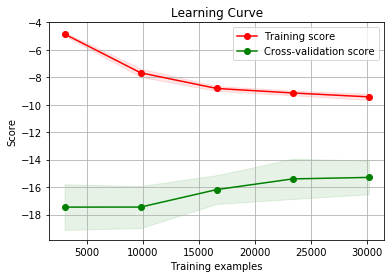

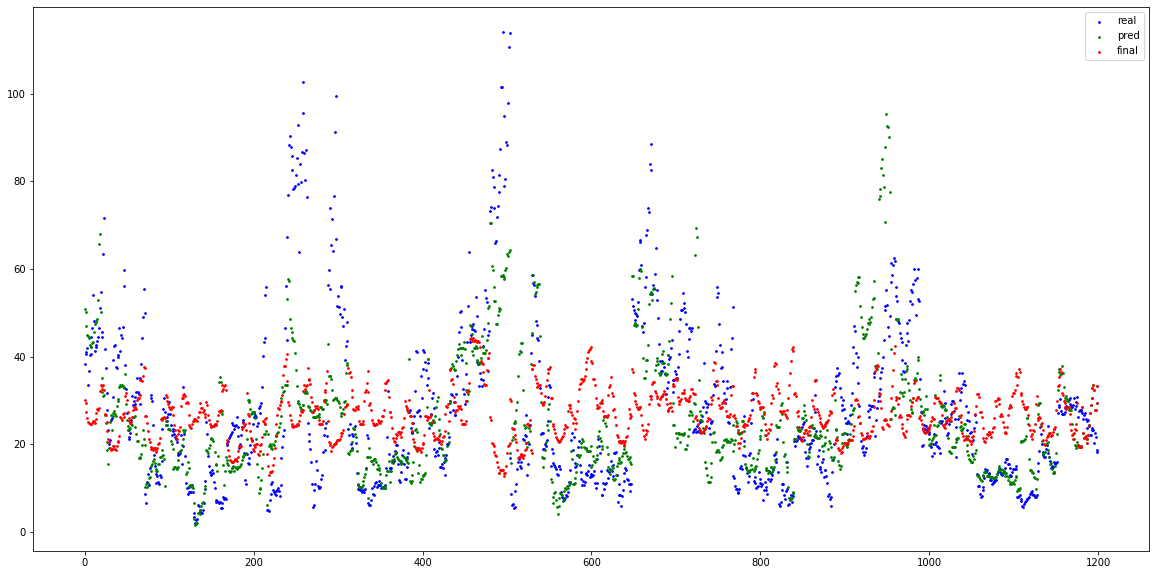

In [41]:
%%time
# parts sequential, time feats, XGBRegressor, 
feats = time_feats
feats = [feat for feat in feats if feat not in black_list_feats]
with_params = {
    'train_parts' : train_parts, 
    'test_parts'  : test_parts,
    'feats'       : feats,
    'model'       : xgb.XGBRegressor,
    'params'      : {'n_jobs': 8,
                     'random_state': 123,
                     'objective': 'reg:squarederror',    #reg:squarederror reg:linear
                     'max_depth': 5,
                     'subsample': 0.95},
    'cv'          : None, #TimeSeriesSplit,
    'folds'       : 4,
    'plot'        : (True, True),
    'csv'         : None,
    'scoring'     : rmse,         #rmse mean_absolute_error r2_score
    'y_log'       : False
}
cv_scores, score, model, y_test_all, y_pred_all, y_final = run_model_parts(**with_params)
print("CV score rmse mean & std", np.mean(cv_scores), np.std(cv_scores))

### predykcja z całkowicie wyszkolonego modelu jest zbliżona do ostatniego odcinka train lub do średniej
### predykcja przyrostowa jest lepiej dopasowana

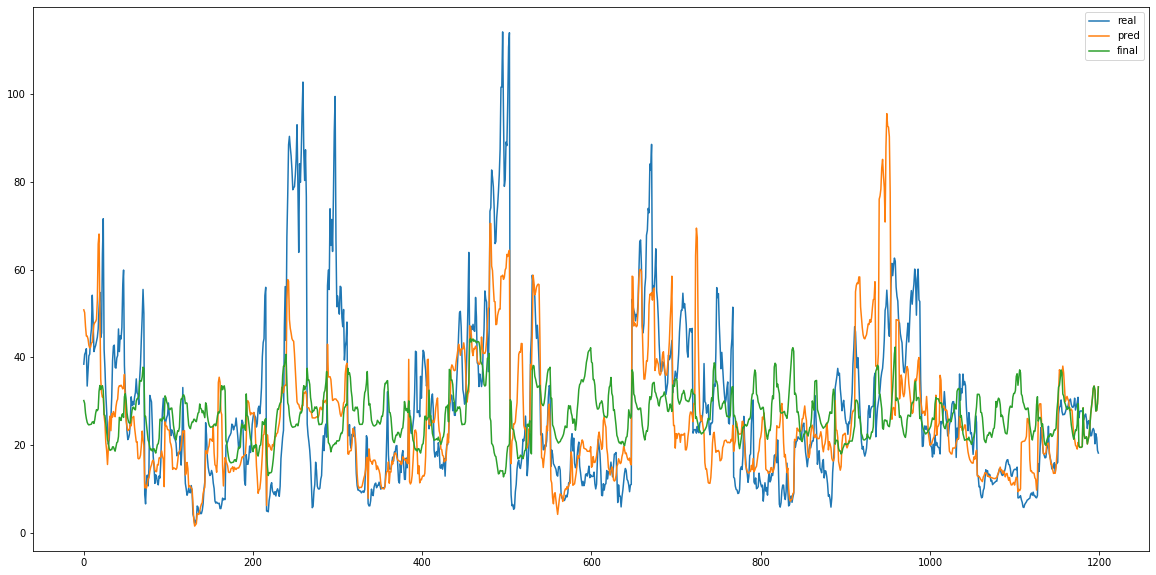

In [42]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(len(y_test_all)), y_test_all, label='real');
plt.plot(np.arange(len(y_pred_all)), y_pred_all, label='pred');
plt.plot(np.arange(len(y_final)), y_final, label='final');
plt.legend()
plt.show;

tss 4
('rmse, mae, r2', 17.84539480023363, 12.684966684457983, 0.12338186495615144)
('rmse, mae, r2', 19.967925274172515, 14.359006750304767, -0.0975492453250828)
14.273184896743064 10.711410200323353

log, tss 4
('rmse, mae, r2', 28.7879355855929, 20.878961974897926, -2062.071346811167)
('rmse, mae, r2', 22.734154519346557, 22.04879472803651, -1285.6215397536291)
21.697613028974402 18.919799790830936

log, no cv
('rmse, mae, r2', 30.20920508362619, 24.38239372105575, -2270.8089067197375)
('rmse, mae, r2', 23.5424505591398, 22.957601185040165, -1378.7377183854117)
25.119243698633976 16.781527576273373

kfold
('rmse, mae, r2', 24.01297860032292, 15.467569137979654, -0.5872677692621975)
('rmse, mae, r2', 20.167365623303123, 15.195751643812306, -0.11958345971687856)
17.180448239453412 16.776630756830425

kfold log
('rmse, mae, r2', 27.90192056961848, 20.020776778960297, -1937.0340315608723)
('rmse, mae, r2', 23.44034311055926, 22.84825930330661, -1366.795377484089)
20.570996139467738 18.850763626529883

no cv
('rmse, mae, r2', 14.963625858210923, 10.191349480539563, 0.3836437394792548)
('rmse, mae, r2', 19.74525017747682, 14.35092272507192, -0.07320678930468105)
11.975816495221636 8.971617362398819

### rmse - root_mean_squared_error - główna metryka
Mean Absolute Error (MAE) - jako uzupełniająca metryka

https://www.tensorflow.org/api_docs/python/tf/compat/v1/metrics/root_mean_squared_error

https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d

https://medium.com/usf-msds/choosing-the-right-metric-for-machine-learning-models-part-1-a99d7d7414e4

https://www.quora.com/How-would-a-model-change-if-we-minimized-absolute-error-instead-of-squared-error-What-about-the-other-way-around

https://stackoverflow.com/questions/17197492/is-there-a-library-function-for-root-mean-square-error-rmse-in-python


rmse nie przekłada się na wielkość średniego błędu - rośnie wraz z wariancją rozkładu częstotliwości wielkości błędu

RMSE value goes down over time because variance is decreasing

RMSE (od ang. root mean square error), czyli średniej kwadratowej błędów, który jest po prostu pierwiastkiem kwadratowym z MSE

RMSE dąży do średniej, MAE do mediany

RMSE ma tendencję do bycia coraz większym niż MAE wraz ze wzrostem wielkości próbki testowej.

Może to stanowić problem przy porównywaniu wyników RMSE obliczonych na próbkach testowych różnej wielkości, co często ma miejsce w modelowaniu w świecie rzeczywistym.


### R^2 (coefficient of determination) regression score function.

Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.

This is not a symmetric function.

Unlike most other scores, R^2 score may be negative (it need not actually be the square of a quantity R).

This metric is not well-defined for single samples and will return a NaN value if n_samples is less than two.

